In [1]:
import numpy as np
import matplotlib.pyplot as plt

## disinhibitory circuit

This is an implementation of the model in Beerendonk et al 2023 (PNAS).

It's a decision making network with three dynamic populations (S1 S2 SPV) and linear rate models for VIP-SOM interneurons.

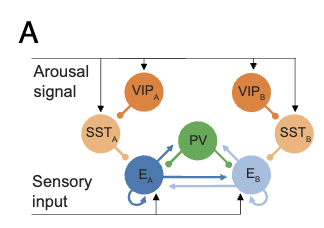

One downside of this model is that it doesn't seem to be a two fixed attractor system. The stimulus needs to be constantly 'on' in order for firing to happen.

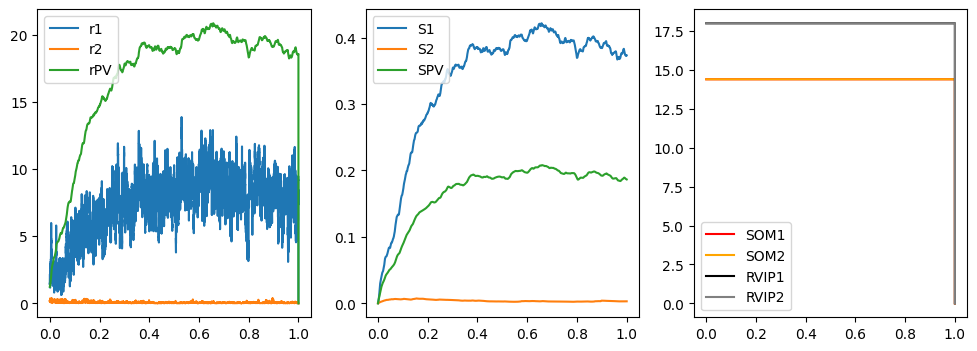

In [70]:
def plot_data(data):
    fig, axs = plt.subplots(1,3, figsize=(12,4))

    axs[0].plot(data['t'], data['R1'], label='r1')
    axs[0].plot(data['t'], data['R2'], label='r2')
    axs[0].plot(data['t'], data['RPV'], label='rPV')
    axs[0].legend()

    axs[1].plot(data['t'], data['S1'], label='S1')
    axs[1].plot(data['t'], data['S2'], label='S2')
    axs[1].plot(data['t'], data['SPV'], label='SPV')
    axs[1].legend()

    axs[2].plot(data['t'], data['RSOM1'], label='SOM1', color = 'red')
    axs[2].plot(data['t'], data['RSOM2'], label='SOM2', color = 'orange')
    axs[2].plot(data['t'], data['RVIP1'], label='RVIP1', color = 'black')
    axs[2].plot(data['t'], data['RVIP2'], label='RVIP2', color = 'grey')
    axs[2].legend()

def params(**kwargs):    
    p = {}
    p['T'] = 1. #s
    p['dt'] = 0.00005 #s

    # Noise
    p['tau_eta'] = 2*1e-3         # s
    p['sigma_1'] = 0.03
    p['sigma_2'] = 0.03 # nA
    p['sigma_PV'] = 0

    # Controls
    p['I_D2'] = 0.5
    p['I_GRIK4'] = 0.5

    # gating variables
    p['S1_init']  = 0
    p['S2_init']  = 0
    p['SPV_init'] = 0
    p['tauN']    = 60.*1e-3  # s
    p['tauG']    = 5.*1e-3   # s
    p['gamma']   = 1.282
    p['gamma_I'] = 2.

    # coupling constants
    p['Jr']  = 0.49     # recurrent
    p['Jc']  = 0.0107   # cross
    p['Jei'] = 0.3597   # excitatory to PV
    p['Jie'] = -0.31    # PV to excitatory
    p['Jii'] = -0.12    # PV self

    p['JVIP'] = -0.1    # VIP to SOM
    p['JSOM'] = -0.001  # SOM to Exc

    # Interneuron FI slopes
    p['betaSOM'] = 32
    p['betaVIP'] = 0
    p['I_ctrl'] = 0.4

    # background input
    p['Ie_1'] = 0.3294
    p['Ie_2'] = 0.3294
    p['Ie_PV'] = 0.26
    
    p['I_stim1'] = 0.08
    p['I_stim2'] = 0.00

    p.update(kwargs)
    return p

def run_threepop(params):
    '''
    Note that for unit consistency, all units are
    time [s]
    current [nA]

    '''
    def F(I, a=135, b=54, d=0.308):
        # Note that th
        return 0.5 * ((a*I - b)/(1 - np.exp(-d*(a*I-b))))
    
    globals().update(params)

    NT = int(T/dt)
    timerange = np.linspace(0,T, NT)

    # =============================
    # ---------- Run --------------
    # =============================

    # Initialize
    S1  = S1_init*np.ones(NT)
    S2  = S2_init*np.ones(NT)
    SPV = SPV_init*np.ones(NT)

    # Noise
    Ieta1  = np.zeros(NT)
    Ieta2  = np.zeros(NT)
    IetaPV = np.zeros(NT)

    # RATES
    R1   = np.zeros(NT)
    R2   = np.zeros(NT)
    RPV  = np.zeros(NT)
    RSOM1 = np.zeros(NT)
    RVIP1 = np.zeros(NT)
    RSOM2 = np.zeros(NT)
    RVIP2 = np.zeros(NT)

    # iterate
    for t_idx, t in enumerate(timerange[:-1]):
        # Stimulus
        # I_stim1 = 0.08*((t > 0) & (t< 10))
        # I_stim2 = 0

        # Interneuron Firing Rate
        RVIP1[t_idx] = np.min((np.max(50*(0.36 + 0.1 * I_D2) + betaVIP), 30))
        RVIP2[t_idx] = np.min((np.max(50*(0.36 + 0.1 * I_D2) + betaVIP), 30))
        RSOM1[t_idx] = (20 * (2 * (0.36 + 0.1) + JVIP*RVIP1[t_idx]) + betaSOM)
        RSOM2[t_idx] = (20 * (2 * (0.36 + 0.1) + JVIP*RVIP2[t_idx]) + betaSOM)

        # Interneuron output
        I_SOM_1 = JSOM * RSOM1[t_idx]
        I_SOM_2 = JSOM * RSOM2[t_idx]

        # Calculate synaptic input
        I1 = Jr*S1[t_idx] + Jc*S2[t_idx] + Jie*SPV[t_idx] + Ie_1 + Ieta1[t_idx] + I_stim1 + I_SOM_1
        I2 = Jc*S1[t_idx] + Jr*S2[t_idx] + Jie*SPV[t_idx] + Ie_2 + Ieta2[t_idx] + I_stim2 + I_SOM_2
        IPV = Jei*S1[t_idx] + Jei*S2[t_idx] + Jii*SPV[t_idx] + Ie_PV + 0.1*I_GRIK4 + IetaPV[t_idx]

        # Transfer function
        R1[t_idx] = F(I1)
        R2[t_idx] = F(I2)

        # Interneuron firing rate
        RPV[t_idx] = np.min((np.max((0,1/4*(615*IPV - 177)+5.5)), 50))

        # OU noise
        Ieta1[t_idx+1] = Ieta1[t_idx] + (dt/tau_eta)*(-Ieta1[t_idx]) + np.sqrt(dt/tau_eta)*sigma_1*np.random.randn()
        Ieta2[t_idx+1] = Ieta2[t_idx] + (dt/tau_eta)*(-Ieta2[t_idx]) + np.sqrt(dt/tau_eta)*sigma_2*np.random.randn()
        IetaPV[t_idx+1] = IetaPV[t_idx] + (dt/tau_eta)*(-IetaPV[t_idx]) + np.sqrt(dt/tau_eta)*sigma_PV*np.random.randn()

        # Update gating
        S1[t_idx+1] = S1[t_idx] + dt*(-S1[t_idx]/tauN + (1 - S1[t_idx])*gamma*R1[t_idx])
        S2[t_idx+1] = S2[t_idx] + dt*(-S2[t_idx]/tauN + (1 - S2[t_idx])*gamma*R2[t_idx])
        SPV[t_idx+1] = SPV[t_idx] + dt*(-SPV[t_idx]/tauG + gamma_I*RPV[t_idx])

    data = {
        't': timerange,
        'R1':  R1,
        'R2':  R2,
        'RPV': RPV,
        'RVIP1': RVIP1,
        'RVIP2': RVIP2,
        'RSOM1':RSOM1,
        'RSOM2':RSOM2,
        'S1':   S1,
        'S2':   S2,
        'SPV': SPV
    }

    return data

data = run_threepop(params(I_D2 = 0, I_GRIK4=0))
plot_data(data)


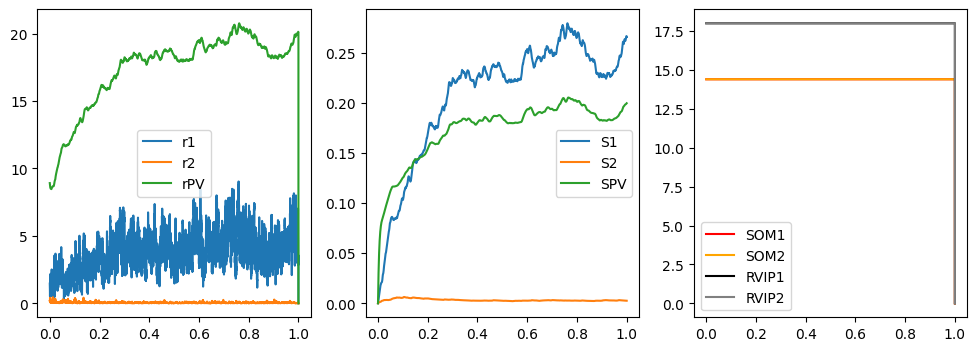

In [71]:
# Suppose we increase GRIK4 path

data_GRIK4 = run_threepop(params(I_D2 = 0, I_GRIK4=0.5))
plot_data(data_GRIK4)

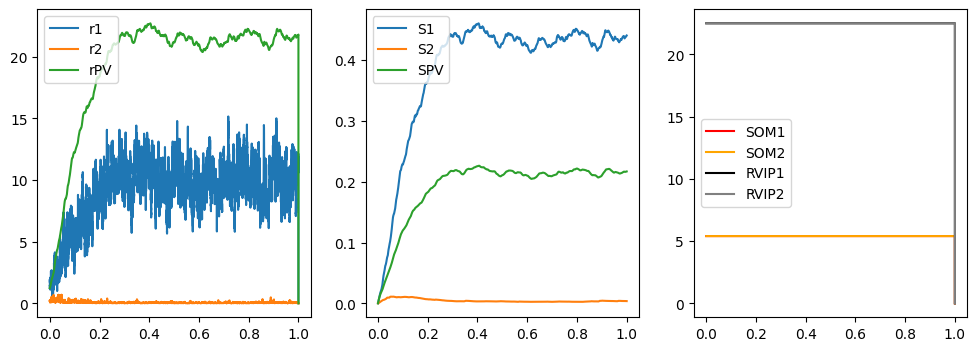

In [72]:

data_GRIK4 = run_threepop(params(I_D2 = 0.9, I_GRIK4=0))
plot_data(data_GRIK4)

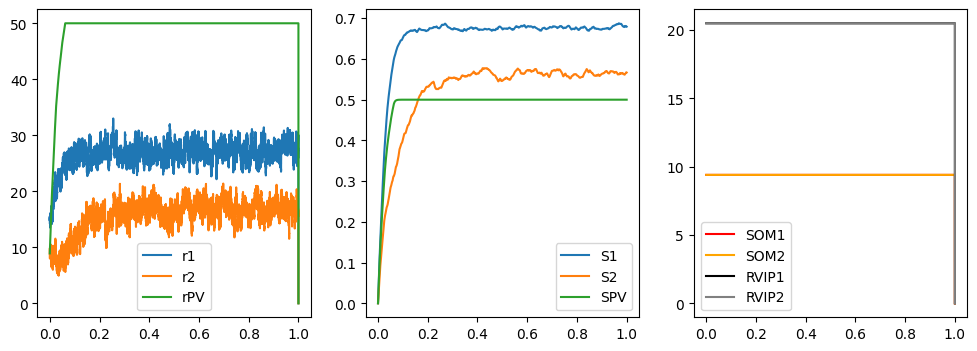

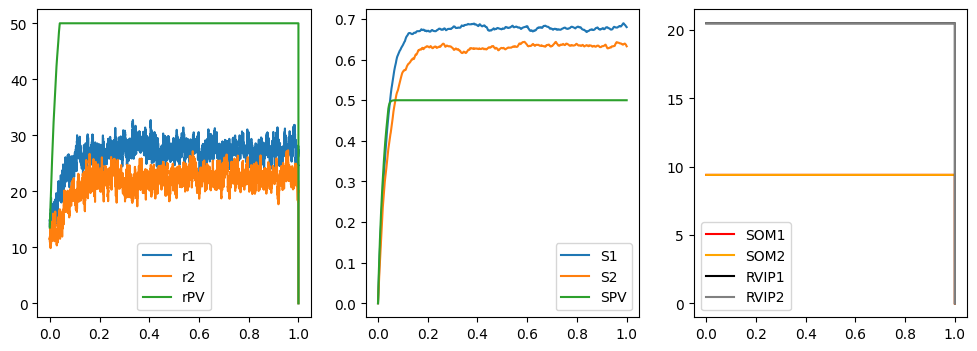

In [81]:
# if stimulus is dense but conflicting, increase GRIK4
# ISTIM1 by default is 

data_conflict_control = run_threepop(params(I_stim1=0.3, I_stim2 = 0.2))
plot_data(data_conflict_control)

data_conflict_control = run_threepop(params(I_stim1=0.3, I_stim2 = 0.25, I_GRIK4=0.8))
plot_data(data_conflict_control)

/var/folders/mn/6_l9d_d134x5hyhjjq894dphkms_d5/T/ipykernel_20829/4193498013.py:78: RuntimeWarning: invalid value encountered in scalar divide
  return 0.5 * ((a*I - b)/(1 - np.exp(-d*(a*I-b))))


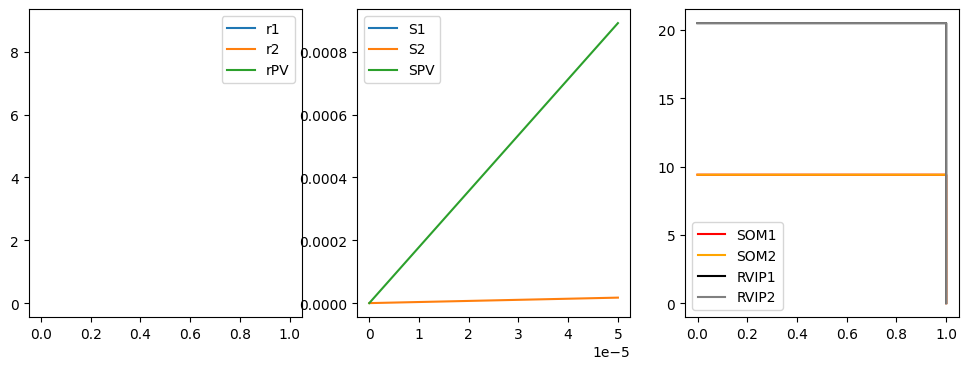

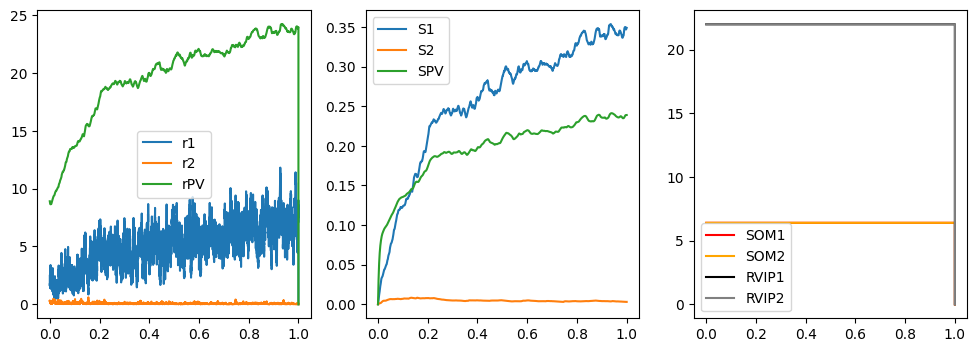

In [88]:
# if data is sparse, use VIP targeting D2

data_sparse_control = run_threepop(params(I_stim1=0.08, I_stim2 = 0.01))
plot_data(data_sparse_control)

data_sparse_test = run_threepop(params(I_stim1=0.08, I_stim2 = 0.01, I_D2=0.8))
plot_data(data_sparse_test)